# Setup

In [ ]:
!pip install nes-py
!pip install gym-super-mario-bros==7.3.0
!pip install setuptools==65.5.0 "wheel<0.40.0"
!pip install gym==0.21.0
!pip install "stable-baselines3[extra]"==1.6.0

In [1]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

done = True
env.reset()

for step in range(5000):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    env.render()
    if done:
        state = env.reset()

env.close()

2024-07-29 16:28:04.256 Python[51666:1777673] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/mb/y9cm90vx579g5v0cb96z19b80000gn/T/org.python.python.savedState
/opt/homebrew/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


# Preprocess

In [2]:
from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from matplotlib import pyplot as plt

In [3]:
env = gym_super_mario_bros.make("SuperMarioBros-v0")
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = GrayScaleObservation(env, keep_dim=True) # scale w one 1/3 
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

In [4]:
state = env.reset()

In [5]:
state.shape

(1, 240, 256, 4)

In [6]:
state, reward, done, info = env.step([env.action_space.sample()])


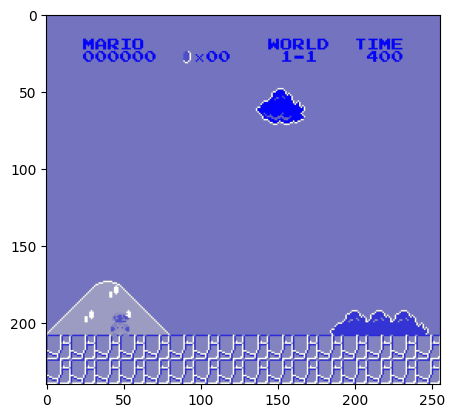

In [7]:
plt.imshow(state[0])

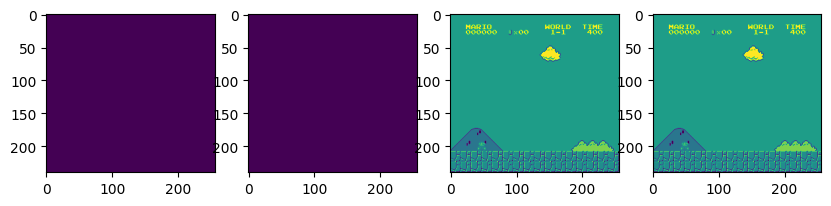

In [8]:
plt.figure(figsize=(10,8))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

# Train 

In [9]:
import os
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

In [10]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self,check_freq,save_path,verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path=save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        return True

In [11]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [12]:
callback = TrainAndLoggingCallback(check_freq=50000, save_path = CHECKPOINT_DIR)

In [13]:
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, n_steps = 512)

Using cpu device
Wrapping the env in a VecTransposeImage.


In [ ]:
model.learn(1000000, callback = callback)

Logging to ./logs/PPO_2


/opt/homebrew/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 157 |
|    iterations      | 1   |
|    time_elapsed    | 3   |
|    total_timesteps | 512 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 26           |
|    iterations           | 2            |
|    time_elapsed         | 39           |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 8.724746e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.95        |
|    explained_variance   | 0.000287     |
|    learning_rate        | 1e-06        |
|    loss                 | 163          |
|    n_updates            | 10           |
|    policy_gradient_loss | -4.01e-05    |
|    value_loss           | 429          |
------------------------------------------


In [ ]:
model = PPO.load('./train/best_model_80000')

In [ ]:
state = env.reset()

while True:
    action, _state = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()
    